# Rise Time Test Notebook

In [111]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
# from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum
from pulse_shape import find_rise_time, plot_rise_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import data
print('cs far')
f_name = '../data/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

cs far
152057 events


In [3]:
# downsample data
cs_down = cs[::10]

<IPython.core.display.Javascript object>


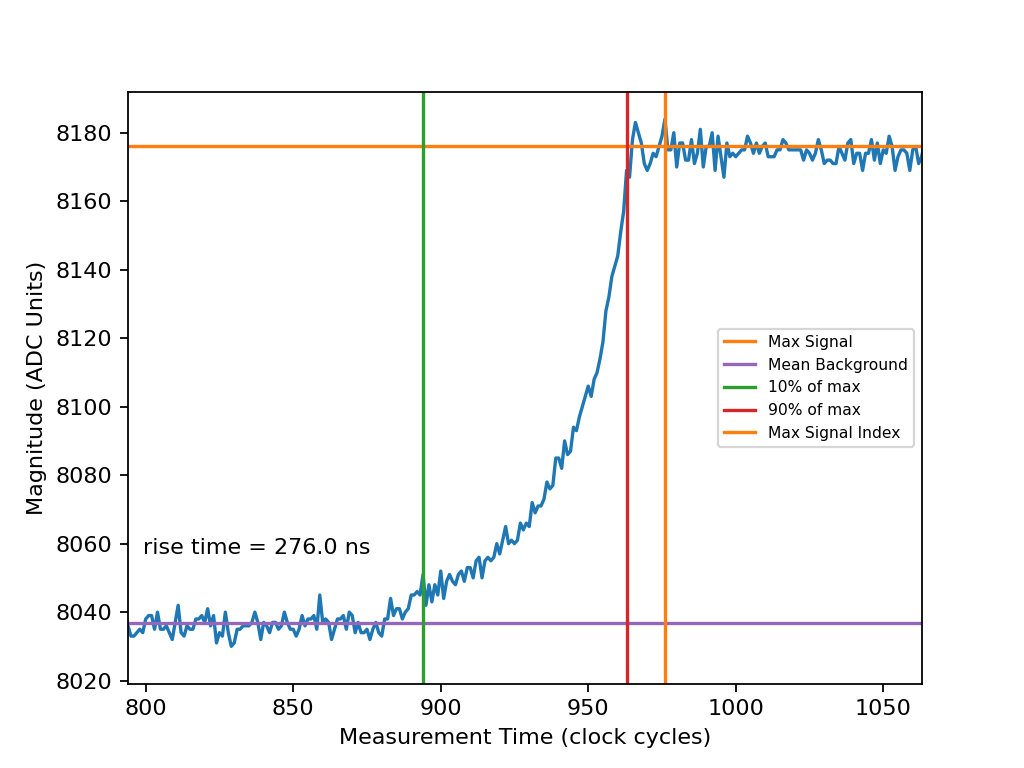

In [29]:
# test/build out code
max_window=10
pulse_num = 3
# function inputs
waveform = cs_down[pulse_num]
pretrigger = [0,500]

# pull out signal and pretrigger bkg
bkg = waveform[pretrigger[0]:pretrigger[1]]
signal = waveform[pretrigger[1]:pretrigger[1]+1000]

# ave background before peak
ave_bkg = bkg.mean()

# subtract background from signal
bkg_corrected_signal = signal - ave_bkg


max_signal = bkg_corrected_signal.max()
# find mean within some window to account for fluctuations
max_signal_index = np.argwhere(bkg_corrected_signal == max_signal).flatten()[0]
max_signal = bkg_corrected_signal[max_signal_index:max_signal_index+max_window].mean()

# find index where 10% of max
t10 = np.argwhere(bkg_corrected_signal >= max_signal*.1).flatten()[0]
t90 = np.argwhere(bkg_corrected_signal >= max_signal*.9).flatten()[0]

risetime = (t90-t10) * 4 * 10**-9 * 10**9

window = 100
plt.figure()
plt.plot(cs_down[pulse_num])
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Measurement Time (clock cycles)')
plt.axhline(max_signal + ave_bkg,label='Max Signal',c='tab:orange')
plt.axhline(ave_bkg,label='Mean Background',c='tab:purple')
plt.axvline(t10+pretrigger[1],label='10% of max',c='tab:green')
plt.axvline(t90+pretrigger[1],label='90% of max',c='tab:red')
plt.axvline(max_signal_index+pretrigger[1],label='Max Signal Index',c='tab:orange')
plt.text(t10+pretrigger[1]-window+5,ave_bkg+20,r'rise time = {:.1f}'.format(risetime)+' ns')
#plt.title('Raw Waveform')
# plt.savefig('figs/example_pulse_raw.png')
plt.legend(fontsize=7)
plt.xlim(t10+pretrigger[1]-window,t90+pretrigger[1]+window)
plt.show()

<IPython.core.display.Javascript object>


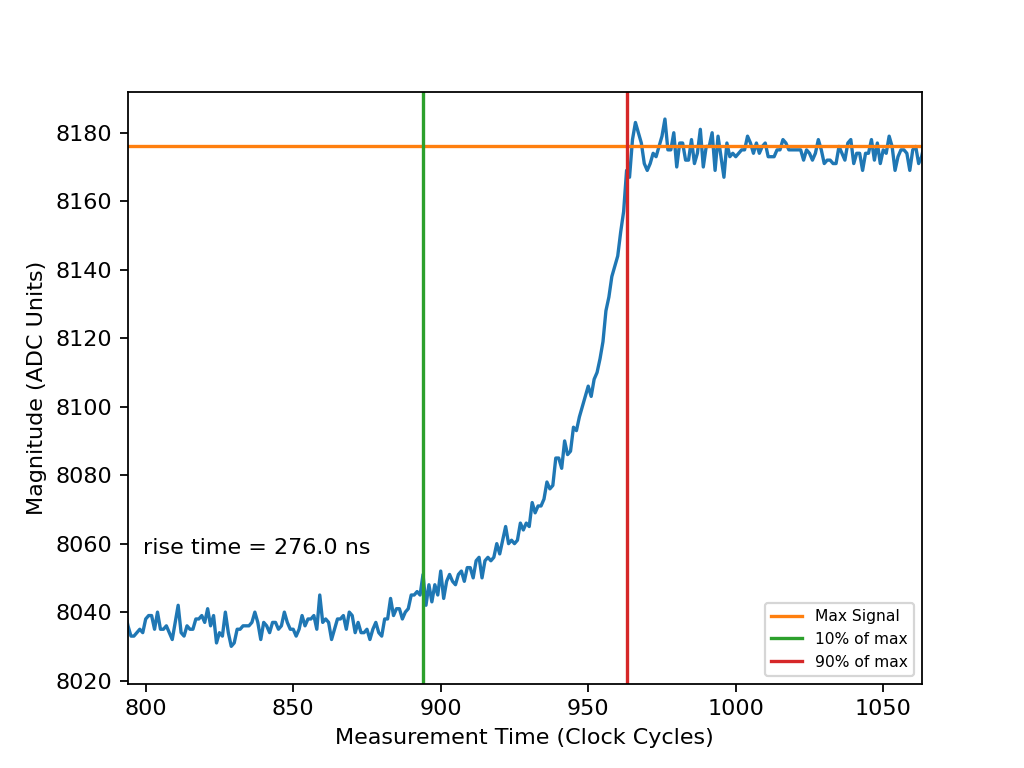

In [124]:
# plotting method
plot_rise_time(cs_down[3])

In [14]:
# find rise times for all data
rise_times = np.zeros(len(cs_down))
for i in range(len(cs_down)):
    rise_times[i] = find_rise_time(cs_down[i])

In [26]:
rise_times.min()*10**9

20.0

In [27]:
rise_times.max()*10**9

2232.0

In [15]:
counts, bins = np.histogram(rise_times,bins=100)
counts

array([   3,  150,  292,  517,  519,  753,  758, 1208, 1824, 3514, 2386,
       1575,  701,  470,  191,  140,   69,   20,   20,    3,   10,    1,
          3,    6,    7,    2,    2,    2,    1,    2,    3,    1,    1,
          0,    0,    0,    0,    2,    0,    1,    0,    2,    2,    3,
          1,    1,    0,    1,    1,    1,    0,    2,    1,    3,    2,
          2,    0,    0,    2,    0,    0,    0,    0,    0,    0,    1,
          0,    1,    2,    1,    1,    1,    0,    1,    1,    2,    1,
          0,    0,    1,    0,    3,    1,    1,    3,    0,    1,    0,
          0,    1,    0,    0,    0,    0,    1,    0,    0,    0,    0,
          1])

In [16]:
bins

array([2.00000e-08, 4.21200e-08, 6.42400e-08, 8.63600e-08, 1.08480e-07,
       1.30600e-07, 1.52720e-07, 1.74840e-07, 1.96960e-07, 2.19080e-07,
       2.41200e-07, 2.63320e-07, 2.85440e-07, 3.07560e-07, 3.29680e-07,
       3.51800e-07, 3.73920e-07, 3.96040e-07, 4.18160e-07, 4.40280e-07,
       4.62400e-07, 4.84520e-07, 5.06640e-07, 5.28760e-07, 5.50880e-07,
       5.73000e-07, 5.95120e-07, 6.17240e-07, 6.39360e-07, 6.61480e-07,
       6.83600e-07, 7.05720e-07, 7.27840e-07, 7.49960e-07, 7.72080e-07,
       7.94200e-07, 8.16320e-07, 8.38440e-07, 8.60560e-07, 8.82680e-07,
       9.04800e-07, 9.26920e-07, 9.49040e-07, 9.71160e-07, 9.93280e-07,
       1.01540e-06, 1.03752e-06, 1.05964e-06, 1.08176e-06, 1.10388e-06,
       1.12600e-06, 1.14812e-06, 1.17024e-06, 1.19236e-06, 1.21448e-06,
       1.23660e-06, 1.25872e-06, 1.28084e-06, 1.30296e-06, 1.32508e-06,
       1.34720e-06, 1.36932e-06, 1.39144e-06, 1.41356e-06, 1.43568e-06,
       1.45780e-06, 1.47992e-06, 1.50204e-06, 1.52416e-06, 1.546

In [61]:
rise_times.mean()*10**9

225.80349861896624

In [57]:
mean_signals = np.argwhere(np.isclose(rise_times,rise_times.mean(),atol=2e-9)).flatten()

<IPython.core.display.Javascript object>


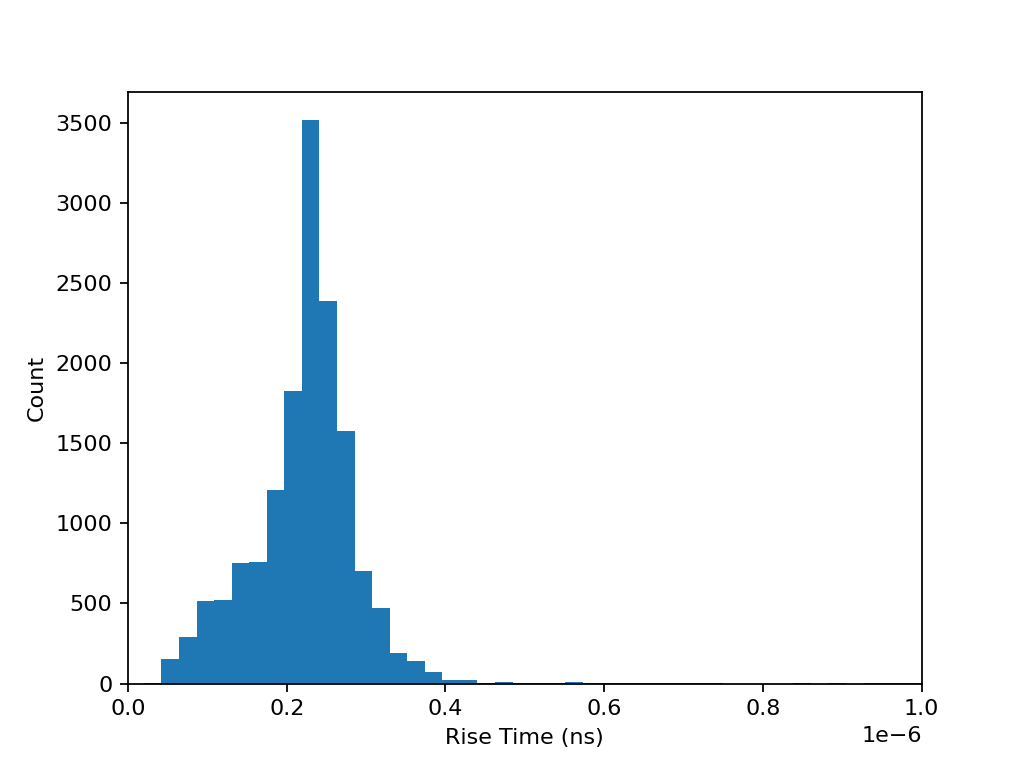

In [18]:
plt.figure()
plt.hist(rise_times,bins=100)
plt.xlim(0,1e-6)
plt.ylabel('Count')
plt.xlabel('Rise Time (ns)')
plt.show()

In [ ]:
mid_mask = rise_times >= bins[9]
mid_mask *= rise_times <= bins[10]
mid_signals = cs_down[mid_mask]

fast_mask = rise_times >= bins[0]
fast_mask *= rise_times <= bins[1]
fast_signals = cs_down[fast_mask]

In [110]:
slow_mask = rise_times >= bins[-19]
slow_mask *= rise_times <= bins[-18]
slow_signals = cs_down[slow_mask]
len(slow_signals)

1

In [90]:
counts

array([   3,  150,  292,  517,  519,  753,  758, 1208, 1824, 3514, 2386,
       1575,  701,  470,  191,  140,   69,   20,   20,    3,   10,    1,
          3,    6,    7,    2,    2,    2,    1,    2,    3,    1,    1,
          0,    0,    0,    0,    2,    0,    1,    0,    2,    2,    3,
          1,    1,    0,    1,    1,    1,    0,    2,    1,    3,    2,
          2,    0,    0,    2,    0,    0,    0,    0,    0,    0,    1,
          0,    1,    2,    1,    1,    1,    0,    1,    1,    2,    1,
          0,    0,    1,    0,    3,    1,    1,    3,    0,    1,    0,
          0,    1,    0,    0,    0,    0,    1,    0,    0,    0,    0,
          1])

<IPython.core.display.Javascript object>


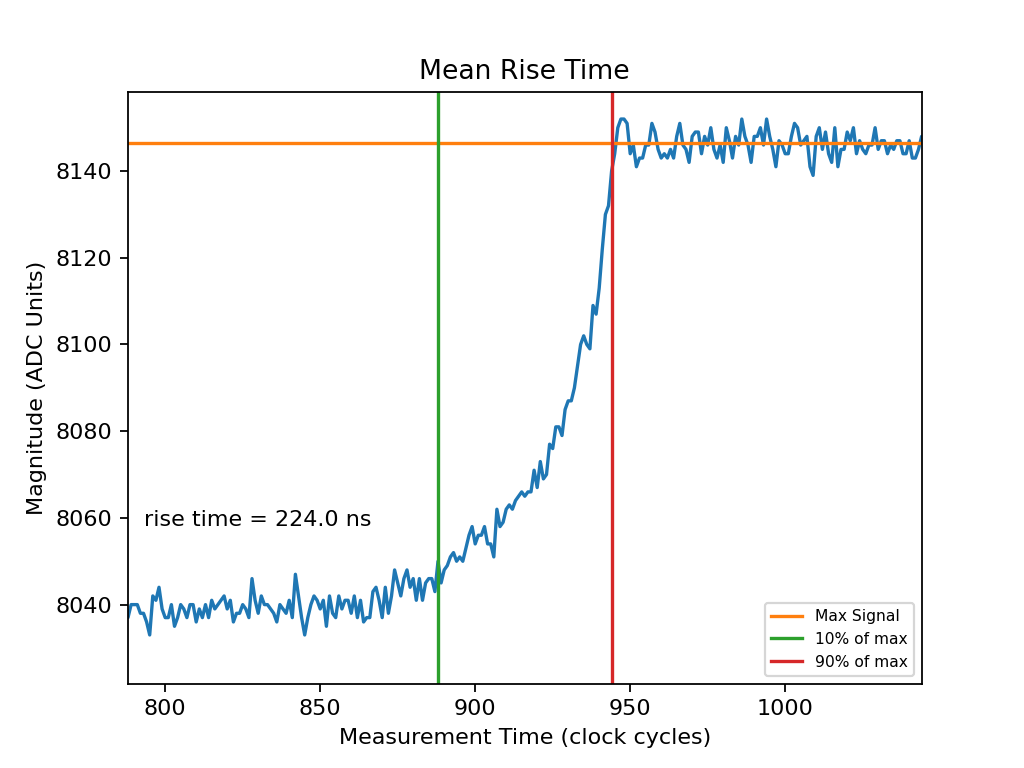

In [76]:
# mid signal
pulse_num = mean_signals[1]
# function inputs
waveform = cs_down[pulse_num]
pretrigger = [0,500]

# pull out signal and pretrigger bkg
bkg = waveform[pretrigger[0]:pretrigger[1]]
signal = waveform[pretrigger[1]:pretrigger[1]+1000]

# ave background before peak
ave_bkg = bkg.mean()

# subtract background from signal
bkg_corrected_signal = signal - ave_bkg
max_signal = bkg_corrected_signal.max()
# find mean within some window to account for fluctuations
max_signal_index = np.argwhere(bkg_corrected_signal == max_signal).flatten()[0]
max_signal = bkg_corrected_signal[max_signal_index:max_signal_index+max_window].mean()

# find index where 10% of max
t10 = np.argwhere(bkg_corrected_signal >= max_signal*.1).flatten()[0]
t90 = np.argwhere(bkg_corrected_signal >= max_signal*.9).flatten()[0]

risetime = (t90-t10) * 4 

window = 100
plt.figure()
plt.plot(cs_down[pulse_num])
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Measurement Time (clock cycles)')
plt.axhline(max_signal + ave_bkg,label='Max Signal',c='tab:orange')
# plt.axhline(ave_bkg,label='Mean Background',c='tab:purple')
plt.axvline(t10+pretrigger[1],label='10% of max',c='tab:green')
plt.axvline(t90+pretrigger[1],label='90% of max',c='tab:red')
plt.text(t10+pretrigger[1]-window+5,ave_bkg+20,r'rise time = {:.1f}'.format(risetime)+' ns')
#plt.title('Raw Waveform')
# plt.savefig('figs/example_pulse_raw.png')
plt.legend(fontsize=7)
plt.title('Mean Rise Time')
plt.xlim(t10+pretrigger[1]-window,t90+pretrigger[1]+window)
plt.show()

<IPython.core.display.Javascript object>


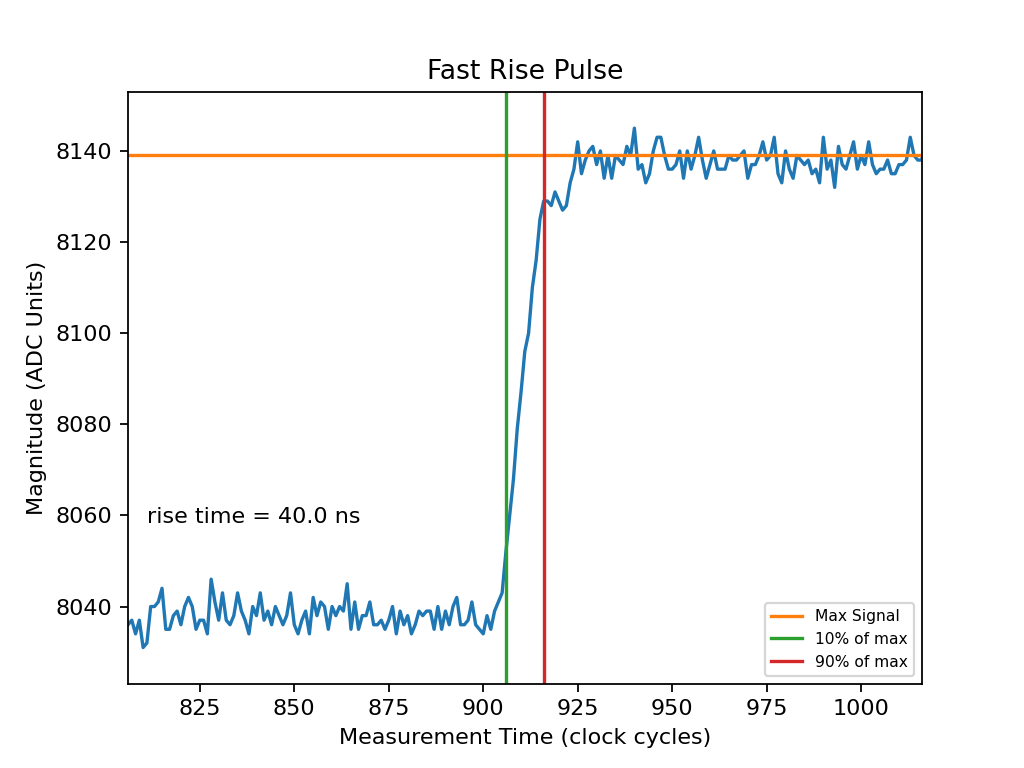

In [77]:
# fast signal
pulse_num = 0
# function inputs
waveform = fast_signals[pulse_num]
pretrigger = [0,500]

# pull out signal and pretrigger bkg
bkg = waveform[pretrigger[0]:pretrigger[1]]
signal = waveform[pretrigger[1]:pretrigger[1]+1000]

# ave background before peak
ave_bkg = bkg.mean()

# subtract background from signal
bkg_corrected_signal = signal - ave_bkg
max_signal = bkg_corrected_signal.max()
# find mean within some window to account for fluctuations
max_signal_index = np.argwhere(bkg_corrected_signal == max_signal).flatten()[0]
max_signal = bkg_corrected_signal[max_signal_index:max_signal_index+max_window].mean()

# find index where 10% of max
t10 = np.argwhere(bkg_corrected_signal >= max_signal*.1).flatten()[0]
t90 = np.argwhere(bkg_corrected_signal >= max_signal*.9).flatten()[0]

risetime = (t90-t10) * 4 

window = 100
plt.figure()
plt.plot(fast_signals[pulse_num])
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Measurement Time (clock cycles)')
plt.axhline(max_signal + ave_bkg,label='Max Signal',c='tab:orange')
# plt.axhline(ave_bkg,label='Mean Background',c='tab:purple')
plt.axvline(t10+pretrigger[1],label='10% of max',c='tab:green')
plt.axvline(t90+pretrigger[1],label='90% of max',c='tab:red')
plt.text(t10+pretrigger[1]-window+5,ave_bkg+20,r'rise time = {:.1f}'.format(risetime)+' ns')
#plt.title('Raw Waveform')
# plt.savefig('figs/example_pulse_raw.png')
plt.legend(fontsize=7)
plt.xlim(t10+pretrigger[1]-window,t90+pretrigger[1]+window)
plt.title('Fast Rise Pulse')
plt.show()

<IPython.core.display.Javascript object>


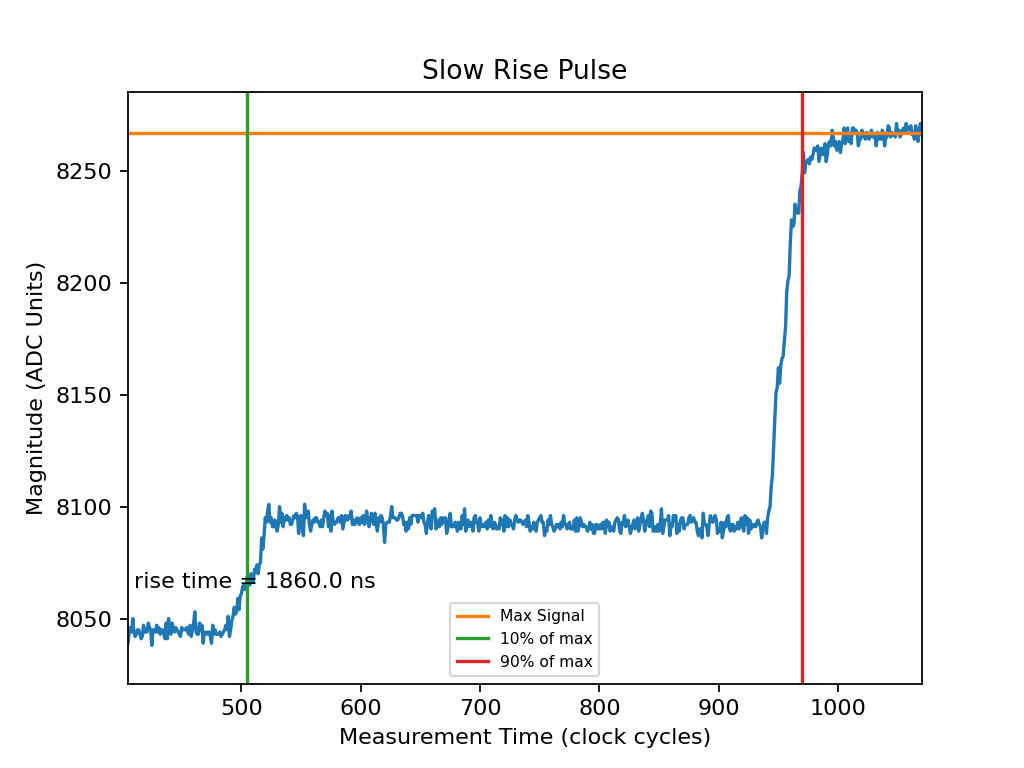

In [109]:
# slow signal
pulse_num = 0
# function inputs
waveform = slow_signals[pulse_num]
pretrigger = [0,500]

# pull out signal and pretrigger bkg
bkg = waveform[pretrigger[0]:pretrigger[1]]
signal = waveform[pretrigger[1]:pretrigger[1]+1000]

# ave background before peak
ave_bkg = bkg.mean()

# subtract background from signal
bkg_corrected_signal = signal - ave_bkg
max_signal = bkg_corrected_signal.max()
# find mean within some window to account for fluctuations
max_signal_index = np.argwhere(bkg_corrected_signal == max_signal).flatten()[0]
max_signal = bkg_corrected_signal[max_signal_index:max_signal_index+max_window].mean()

# find index where 10% of max
t10 = np.argwhere(bkg_corrected_signal >= max_signal*.1).flatten()[0]
t90 = np.argwhere(bkg_corrected_signal >= max_signal*.9).flatten()[0]
risetime = (t90-t10) * 4 

# plotting
window = 100
plt.figure()
plt.plot(slow_signals[pulse_num])
plt.axhline(max_signal + ave_bkg,label='Max Signal',c='tab:orange')
plt.axvline(t10+pretrigger[1],label='10% of max',c='tab:green')
plt.axvline(t90+pretrigger[1],label='90% of max',c='tab:red')
plt.text(t10+pretrigger[1]-window+5,ave_bkg+20,r'rise time = {:.1f}'.format(risetime)+' ns')
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Measurement Time (clock cycles)')
plt.title('Slow Rise Pulse')
plt.legend(fontsize=7)
plt.xlim(t10+pretrigger[1]-window,t90+pretrigger[1]+window)
plt.show()